# Blackbird Optimal Control

This notebook goes into using neural networks for optimal control. The Blackbird set has multiple flight paths but control scheme for the quadcopter is a nonlinear inverse dynamic controller. This notebook is exploring various neural networks for trying to learn the optimal controller.

## Load in data

Setting up libraries that will be needed as well as a function to download a flight test from the Blackbird Dataset

In [1]:
import copy
import importlib
import os
import sys
import time
sys.path.append(os.path.abspath('../functions'))

import read_blackbird_dataset as rbd
import dsp
import quaternions

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numba
import numpy as np
import pandas as pd

from sklearn import model_selection
import tensorflow as tf

# Please work
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Initial read in flight test
def cleaned_blackbird_test(maneuver, yaw_direction, max_speed):
    test_df = rbd.read_blackbird_test(maneuver, yaw_direction, max_speed)
    rbd.imu_installation_correction(test_df)
    test_df = rbd.inertial_position_derivatives_estimation(test_df)
    test_df = rbd.gyroscope_derivatives_estimation(test_df)
    test_df = rbd.consistent_quaternions(test_df)
    test_df = rbd.inertial_quaternion_derivatives_estimation(test_df)
    test_df = rbd.body_quaternion_angular_derivative_estimate(test_df)
    test_df = rbd.motor_scaling(test_df)
    test_df = rbd.motor_rates(test_df)
    test_df = rbd.quaternion_body_acceleration(test_df)
    test_df = rbd.detrend_pwm(test_df)
    test_df = rbd.scale_and_filter_pwms(test_df)
    test_df = rbd.on_ground(test_df)  # Must be last function
    return test_df

test_df = cleaned_blackbird_test('figure8', 'Constant', 0.5)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 781699 entries, 1526617312016142000 to 1526617526748159000
Data columns (total 95 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PWM1                            39823 non-null   float64
 1   PWM1_f                          39823 non-null   float64
 2   PWM2                            39823 non-null   float64
 3   PWM2_f                          39823 non-null   float64
 4   PWM3                            39823 non-null   float64
 5   PWM3_f                          39823 non-null   float64
 6   PWM4                            39823 non-null   float64
 7   PWM4_f                          39823 non-null   float64
 8   angular_velocity_covariance     21298 non-null   object 
 9   ax_B_[m/s2]                     77287 non-null   float64
 10  ax_I_[m/s2]                     77287 non-null   float64
 11  ax_[m/s2]                       21298 non-null 

In [3]:
pwms_df = test_df[['PWM1_f', 'PWM2_f', 'PWM3_f', 'PWM4_f']].dropna()
tvec = (pwms_df.index - test_df.index[0]) * (10**-9)
tvec = tvec.astype('float').values
pwms = pwms_df.values

fig = plt.figure()

ax = fig.add_axes([0.15, 0.1, 0.8, 0.8])
ax.plot(tvec, pwms[:, 0], label='PWM1')
ax.plot(tvec, pwms[:, 1], label='PWM2')
ax.plot(tvec, pwms[:, 2], label='PWM3')
ax.plot(tvec, pwms[:, 3], label='PWM4')

ax.set_xlabel("Time ($t$) [sec]")
ax.set_ylabel("Pulse Width Modulation [$\mu$sec]")
ax.legend()
ax.grid()
plt.show()

<IPython.core.display.Javascript object>

## Creating Training and Test Sets

The idea is that given the data in a past time window and given the future commanded position and orientation in future, then the a sequence of nominal command values can be given. The nominal command values can form the bases for a nonlinear control around some inner controller that closes the loop.

In [47]:
# Get a function to generate data based on windowing
def generate_test_data(test_df, past_delta_t, future_delta_t, downsample_dict=None):
    """
    Args:
        test_df (pd.DataFrame): Flight test data frame to look at
        past_delta_t (float): time in seconds to gather past data in [current_time - past_delta_t, current_time] window.
        future_delta_t (float): time in seconds to gather past data in [current_time, current_time + future_delta_t] window.
        dowsample_dict (dict): dictionary whose keys are the variables used in training and tests with positive integers 
                                for relative downsample rate. The keys are stride_var with var being pos, att, pos_ref, 
                                att_ref, motor_speeds, accel, gyro, or pwms.
    """
    
    # Dictionary default
    if downsample_dict is None:
        downsample_dict = {
            'stride_pos': 1,
            'stride_att': 1,
            'stride_pos_ref': 1,
            'stride_att_ref': 1,
            'stride_motor_speeds': 1,
            'stride_accel': 1,
            'stride_gyro': 1,
            'stride_pwms': 1
        }
    
    # Get inputs to optimal control sequence
    # pos., att., ref pos., ref att. ,motor speeds., acc., gyro
    pos = test_df[['px_[m]', 'py_[m]', 'pz_[m]']].dropna()
    pos_ref = test_df[['pxr_[m]', 'pyr_[m]', 'pzr_[m]']].dropna()
    att = test_df[['qw', 'qx', 'qy', 'qz']].dropna()
    att_ref = test_df[['qwr', 'qxr', 'qyr', 'qzr']].dropna()
    motor_speeds = test_df[['rpm1', 'rpm2', 'rpm3', 'rpm4']].dropna()
    accel = test_df[['ax_[m/s2]', 'ay_[m/s2]', 'az_[m/s2]']].dropna()
    gyro = test_df[['omegax_[dps]', 'omegay_[dps]', 'omegaz_[dps]']].dropna()

    # Get control
    pwms = test_df[test_df['is_flying']]
    pwms = pwms[['PWM1_f', 'PWM2_f', 'PWM3_f', 'PWM4_f']].dropna()
    
    # Get time vectors for history
    def get_tvec(state_df):
        tvec = (state_df.index - test_df.index[0]) * (10**-9)
        tvec = tvec.astype('float')
        return tvec.values
    
    # Time Vector
    t_pos = get_tvec(pos)
    t_att = get_tvec(att)
    t_pref = get_tvec(pos_ref)
    t_aref = get_tvec(att_ref)
    t_motors = get_tvec(motor_speeds)
    t_acc = get_tvec(accel)
    t_gyro = get_tvec(gyro)
    t_pwms = get_tvec(pwms)
    
    # Dataframe to numpy
    def df_to_numpy(state_df):
        return state_df.values
    
    pos = df_to_numpy(pos)
    att = df_to_numpy(att)
    pos_ref = df_to_numpy(pos_ref)
    att_ref = df_to_numpy(att_ref)
    motor_speeds = df_to_numpy(motor_speeds)
    accel = df_to_numpy(accel)
    gyro = df_to_numpy(gyro)
    pwms = df_to_numpy(pwms)

    # Scaling all numpy data to [0,1] range or [-1,1] range based either on flight test bounds or hardware bounds
    pos = pos/5.  # All flight tests are within 10m cube with Z being [-5,0]
    pos_ref = pos_ref/5.
    # attitude is already a unit scaling
    """
    From initial BB notebook, 0.125 change in frac. throttle gives ~2500 rpm change. Snail gives 2400 rpm/V so if
    assuming linear scaling for rpm a max of 20,000 rpm and a voltage of 8.33 V. From reference it looks like 3S LiPo 
    battery with nominal voltage of 11.1 V. Seems to be short a cell for traditional race/freestyle quads.
    
    Snail:
        https://www.dji.com/snail/info#specs
        https://dl.djicdn.com/downloads/snail/20170315/SNAIL+2305+Racing+Motor_multi.pdf
    Other:
        https://www.getfpv.com/learn/new-to-fpv/all-about-multirotor-fpv-drone-battery/#:~:text=The%20lithium%20battery%20packs%20used,4.35V%20at%20full%20charge.
    """
    motor_speeds = motor_speeds/20000.
    # https://www.xsens.com/hubfs/Downloads/Manuals/MTi-1-series-datasheet.pdf?hsCtaTracking=6999e406-3b81-44e2-8e2d-5ecf00e23d87%7Ced790e48-f312-4c41-ad3b-50931a26a420
    accel = accel/(2*9.81)  # Full scale is +/- 16 g's but I think 2 will be fine
    gyro = gyro/1000.  # Full scale is +/- 20000 deg/s
    pwms = (pwms - 1000.)/1000.
    
    
    
    # Determine deltas for windowing
    dt_pos = np.median(np.diff(t_pos))
    dt_att = np.median(np.diff(t_att))
    dt_pref = np.median(np.diff(t_pref))
    dt_aref = np.median(np.diff(t_aref))
    dt_motors = np.median(np.diff(t_motors))
    dt_acc = np.median(np.diff(t_acc))
    dt_gyro = np.median(np.diff(t_gyro))
    dt_pwms = np.median(np.diff(t_pwms)) # The medium will take care of any gaps
    
    # Find number of state values
    n_pos = int(np.floor(past_delta_t/dt_pos))
    n_att = int(np.floor(past_delta_t/dt_att))
    n_pref = int(np.floor(future_delta_t/dt_pref))
    n_aref = int(np.floor(future_delta_t/dt_aref))
    n_motors = int(np.floor(past_delta_t/dt_motors))
    n_acc = int(np.floor(past_delta_t/dt_acc))
    n_gyro = int(np.floor(past_delta_t/dt_gyro))
    n_pwms = int(np.floor(future_delta_t/dt_pwms))
    
    # Record this in a dictionary
    info = {
        'vicon position': (n_pos, dt_pos),
        'vicon attitude': (n_att, dt_att),
        'reference position': (n_pref, dt_pref),
        'reference attitude': (n_aref, dt_aref),
        'motor speeds': (n_motors, dt_motors),
        'accelerometer': (n_acc, dt_acc),
        'gyroscope': (n_gyro, dt_gyro),
        'PWM': (n_pwms, dt_pwms)
    }
    
    # Preallocate input and output vectors
    N = t_pwms.shape[0] - n_pwms + 1 # Edit N to mai
    X = np.zeros((
        N,
        int(np.ceil(n_pos/downsample_dict['stride_pos']))*pos.shape[1] + 
        int(np.ceil(n_att/downsample_dict['stride_att']))*att.shape[1] + 
        int(np.ceil(n_pref/downsample_dict['stride_pos_ref']))*pos_ref.shape[1] + 
        int(np.ceil(n_aref/downsample_dict['stride_att_ref']))*att_ref.shape[1] + 
        int(np.ceil(n_motors/downsample_dict['stride_motor_speeds']))*motor_speeds.shape[1] +
        int(np.ceil(n_acc/downsample_dict['stride_accel']))*accel.shape[1] + 
        int(np.ceil(n_gyro/downsample_dict['stride_gyro']))*gyro.shape[1]
    ))
    Y = np.zeros((N, int(np.ceil(n_pwms/downsample_dict['stride_pwms']))*pwms.shape[1]))
    tvec_y = np.zeros((N, int(np.ceil(n_pwms/downsample_dict['stride_pwms']))))
    
    """
    # Loop through (~ 180 secs)
    for i in range(N):
        # allocate output values
        Y[i,:] = pwms[i:i+n_pwms, :].flatten('F')
        
        # Sampling time
        t_sample = t_pwms[i]
        
        # Accumulate input states
        pos_line = pos[t_pos <= t_sample, :][-n_pos:, :].flatten('F')
        att_line = att[t_att <= t_sample, :][-n_att:, :].flatten('F')
        pref_line = pos_ref[t_sample <= t_pref, :][:n_pref, :].flatten('F')
        aref_line = att_ref[t_sample <= t_aref, :][:n_aref, :].flatten('F')
        motors_line = motor_speeds[t_motors <= t_sample, :][-n_motors:, :].flatten('F')
        acc_line = accel[t_acc <= t_sample, :][-n_acc:, :].flatten('F')
        gyro_line = gyro[t_gyro <= t_sample, :][-n_gyro:, :].flatten('F')
        
        # Put input states into input row already flattened
        X[i, :] = np.concatenate((
            pos_line, pref_line, att_line, aref_line, motors_line, acc_line, gyro_line
        ))
    
        # Update expected time
        tvec_y[i, :] = t_sample + dt_pwms*np.arange(0, n_pwms)
    """
    
    # ~100 secs
    @numba.jit(nopython=True)
    def fast_generator(
        X, Y, tvec_y,
        pos, att, pos_ref, att_ref, motor_speeds, accel, gyro, pwms,
        n_pos, n_att, n_pref, n_aref, n_motors, n_acc, n_gyro, n_pwms,
        stride_pos, stride_att, stride_pos_ref, stride_att_ref, stride_motor_speeds, stride_accel, stride_gyro, stride_pwms
    ):
        pwm_length = int(Y.shape[1]/4)
        for i in numba.prange(N):
            # allocate output values
            for j in range(pwms.shape[1]):
                Y[i,j*pwm_length:(j+1)*pwm_length] = pwms[i:i+n_pwms:stride_pwms, j]

            # Sampling time
            t_sample = t_pwms[i]

            def numba_2d_fortran_flatten(X):
                Xflattened = np.zeros((X.shape[0]*X.shape[1],))
                ni = X.shape[0]
                for j in range(X.shape[1]):
                    Xflattened[j*ni:(j+1)*ni] = X[:,j]
                return Xflattened
            
            # Accumulate input states
            # Position
            pos_line = numba_2d_fortran_flatten(pos[t_pos <= t_sample, :][-n_pos::stride_pos, :])
            att_line = numba_2d_fortran_flatten(att[t_att <= t_sample, :][-n_att::stride_att, :])
            pref_line = numba_2d_fortran_flatten(pos_ref[t_sample <= t_pref, :][:n_pref:stride_pos_ref, :])
            aref_line = numba_2d_fortran_flatten(att_ref[t_sample <= t_aref, :][:n_aref:stride_att_ref, :])
            motors_line = numba_2d_fortran_flatten(motor_speeds[t_motors <= t_sample, :][-n_motors::stride_motor_speeds, :])
            acc_line = numba_2d_fortran_flatten(accel[t_acc <= t_sample, :][-n_acc::stride_accel, :])
            gyro_line = numba_2d_fortran_flatten(gyro[t_gyro <= t_sample, :][-n_gyro::stride_gyro, :])

            # Put input states into input row already flattened
            if X.shape[1] == (pos_line.shape[0] + pref_line.shape[0] +
                              att_line.shape[0] + aref_line.shape[0] +
                              motors_line.shape[0] + 
                              acc_line.shape[0] + gyro_line.shape[0]):
                X[i, :] = np.concatenate((
                    pos_line, pref_line, att_line, aref_line, motors_line, acc_line, gyro_line
                ))
            else:
                X[i, :] = np.nan

            # Update expected time
            tvec_y[i, :] = t_sample + dt_pwms*(np.arange(0, n_pwms)[::stride_pwms])
    
    fast_generator(
        X, Y, tvec_y, 
        pos, att, pos_ref, att_ref, motor_speeds, accel, gyro, pwms,
        n_pos, n_att, n_pref, n_aref, n_motors, n_acc, n_gyro, n_pwms,
        **downsample_dict
    )
    
    # Get rid of invalid segments
    ind_valid = np.all(np.isfinite(X), axis=1)
    X = X[ind_valid]
    Y = Y[ind_valid]
    tvec_y = tvec_y[ind_valid]
    
    return (X, Y, tvec_y, info)

# It took 0.687284 seconds to do everything up to all the sorting

if True:
    t1 = time.time()
    _, _, _, output = generate_test_data(test_df, 0.05, 0.05)
    t2 = time.time()
    print("Elapsed time is %f [s]" % (t2-t1))
    print("Output Summary")
    for k in output.keys():
        n, dt = output[k]
        print("\t%s: %i [samples]\t%f [Hz]" %(k, n, 1./dt))

Elapsed time is 86.365744 [s]
Output Summary
	vicon position: 17 [samples]	359.971202 [Hz]
	vicon attitude: 17 [samples]	359.971202 [Hz]
	reference position: 9 [samples]	188.465888 [Hz]
	reference attitude: 9 [samples]	188.465888 [Hz]
	motor speeds: 9 [samples]	187.899286 [Hz]
	accelerometer: 5 [samples]	100.000000 [Hz]
	gyroscope: 5 [samples]	100.000000 [Hz]
	PWM: 9 [samples]	187.934599 [Hz]


## Initial Training 

Training a simple network to get a baseline model before attempting to try and parameter tuning with regards to window lengths or network size.

In [48]:
downsample_dict = {
            'stride_pos': 36,
            'stride_att': 36,
            'stride_pos_ref': 19,
            'stride_att_ref': 19,
            'stride_motor_speeds': 19,
            'stride_accel': 10,
            'stride_gyro': 10,
            'stride_pwms': 19
        }
X, Y, tvec_y, output = generate_test_data(test_df, 1., 1., downsample_dict)
print("Output Summary")
for ko, kd in zip(output.keys(), downsample_dict.keys()):
    n, dt = output[ko]
    d = downsample_dict[kd]
    print("\t%s: %i [samples]\t%f [Hz]" %(ko, int(np.ceil(n/d)), 1./(dt*d)))

Output Summary
	vicon position: 10 [samples]	9.999200 [Hz]
	vicon attitude: 10 [samples]	9.999200 [Hz]
	reference position: 10 [samples]	9.919257 [Hz]
	reference attitude: 10 [samples]	9.919257 [Hz]
	motor speeds: 10 [samples]	9.889436 [Hz]
	accelerometer: 10 [samples]	10.000000 [Hz]
	gyroscope: 10 [samples]	10.000000 [Hz]
	PWM: 10 [samples]	9.891295 [Hz]


In [49]:
dX = X.shape[1]
dY = Y.shape[1]

# Build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=X.shape[1:]))
for n in range(2,10):
    model.add(tf.keras.layers.Dense(max(dY, int(dX/n)), activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(Y.shape[1], activation=tf.nn.relu))

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.mse,
    metrics=['mse'],
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 120)               28920     
_________________________________________________________________
dense_19 (Dense)             (None, 80)                9680      
_________________________________________________________________
dense_20 (Dense)             (None, 60)                4860      
_________________________________________________________________
dense_21 (Dense)             (None, 48)                2928      
_________________________________________________________________
dense_22 (Dense)             (None, 40)                1960      
_________________________________________________________________
dense_23 (Dense)             (None, 40)               

In [50]:
# Training
"""
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='mse', patience=10
)
"""
tf.random.set_seed(42)  # Meaning of life

hist = model.fit(
    x=X, y=Y,
    batch_size=100,
    epochs=100,
    verbose=1,
    validation_split=0.3,  # 70-30 train validation split
    shuffle=True,
    validation_freq=1,
)

Train on 26662 samples, validate on 11427 samples
Epoch 1/100
26662/26662 [==============================] - 2s 80us/sample - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 2/100
26662/26662 [==============================] - 1s 56us/sample - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 3/100
26662/26662 [==============================] - 1s 53us/sample - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 4/100
26662/26662 [==============================] - 1s 53us/sample - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 5/100
26662/26662 [==============================] - 1s 51us/sample - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 6/100
26662/26662 [==============================] - 1s 56us/sample - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 7/100
26662/26662 [==============================] - 2s 58us/sample - loss: 0.0170 - mse: 0.0170 - val_l

Epoch 59/100
26662/26662 [==============================] - 1s 51us/sample - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 60/100
26662/26662 [==============================] - 1s 52us/sample - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 61/100
26662/26662 [==============================] - 1s 52us/sample - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 62/100
26662/26662 [==============================] - 1s 52us/sample - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 63/100
26662/26662 [==============================] - 1s 51us/sample - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 64/100
26662/26662 [==============================] - 1s 52us/sample - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 65/100
26662/26662 [==============================] - 1s 55us/sample - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 66/100


<IPython.core.display.Javascript object>


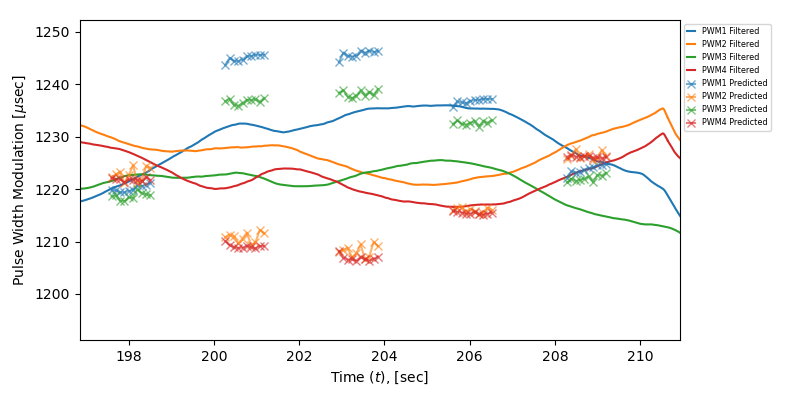

In [54]:
# plot predicted versus actual outputs
fig = plt.figure()
fig.set_size_inches(8,4)

ax = fig.add_axes([0.1, 0.15, 0.75, 0.8])

ypred = 1000.*model.predict(X) + 1000.
ypred = ypred.reshape((ypred.shape[0], int(ypred.shape[1]/4.), 4), order='F')

n = 500 # 1000

ax.plot(tvec, pwms[:,0], label='PWM1 Filtered')
ax.plot(tvec, pwms[:,1], label='PWM2 Filtered')
ax.plot(tvec, pwms[:,2], label='PWM3 Filtered')
ax.plot(tvec, pwms[:,3], label='PWM4 Filtered')

for i in range(int(ypred.shape[0]/n)):
    for j in range(4):
        ax.plot(
            tvec_y[n*i, :],
            ypred[n*i, :, j],
            color=('C%i' % j),
            marker='x',
            alpha=0.6,
            label=(('' if i == 0  else '_') + ('PWM%i' % (j+1)) + ' Predicted')
        )

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='xx-small', handlelength=1)

ax.set_xlabel('Time ($t$), [sec]')
ax.set_ylabel('Pulse Width Modulation [$\mu$sec]')
plt.show()

<IPython.core.display.Javascript object>


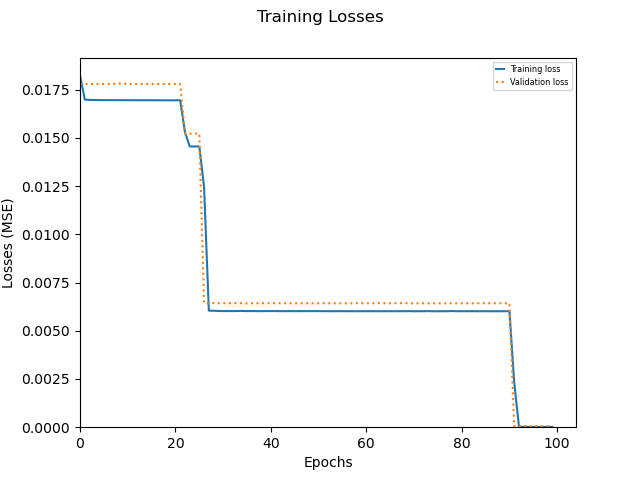

In [55]:
fig, ax_t = plt.subplots(1, 1)

lvec = np.array(hist.history['loss'])
vlvec = np.array(hist.history['val_loss'])
epoch_vec = np.array(list(range(lvec.shape[0])))
    
ax_t.plot(epoch_vec, lvec, label='Training loss')
ax_t.plot(epoch_vec, vlvec, linestyle=':', label='Validation loss')

ax_t.set_xlim(left=0)
ax_t.set_ylim(bottom=0)

fig.suptitle('Training Losses')
ax_t.legend(fontsize='xx-small', handlelength=1)
ax_t.set_xlabel('Epochs')
ax_t.set_ylabel('Losses (MSE)')
plt.show()

In [53]:
# plt.close('all')